In [51]:
import pandas as pd 
import numpy as np 
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_curve
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import warnings

In [52]:
warnings.filterwarnings('ignore')

df = pd.read_csv('../league_dataset_60k.csv')
column_keys = df.keys()
scaler = StandardScaler()

#pop the string label and win output before normalisation
teampos = df.pop("teamPosition")
win = df.pop("win")

df = scaler.fit_transform(df)

df = np.column_stack((teampos, df))
df = pd.DataFrame(np.column_stack((df, win)), columns=column_keys)

grouped = df.groupby(df.teamPosition)
data_mid = grouped.get_group("MIDDLE")

## A Peek inside the Datasets

In [53]:
data_mid.head(5)

,teamPosition,12AssistStreakCount,abilityUses,acesBefore15Minutes,alliedJungleMonsterKills,baronTakedowns,blastConeOppositeOpponentCount,bountyGold,buffsStolen,completeSupportQuestInTime,...,trueDamageTaken,turretKills,turretsLost,unrealKills,visionClearedPings,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win
2,MIDDLE,-0.253558,1.82462,-0.0775217,-0.502936,-0.630049,-0.0978071,1.21806,1.14563,-0.359552,...,0.441421,-0.0501248,0.40087,0,-0.155974,-0.23869,-0.844007,0.173053,-0.286289,0
7,MIDDLE,-0.253558,0.100233,-0.0775217,-0.569079,-0.630049,-0.0978071,0.642097,-0.426471,-0.359552,...,1.43221,-0.796455,0.123476,0,-0.155974,0.408745,1.5144,-0.706373,0.441176,1
12,MIDDLE,-0.253558,-0.973038,-0.0775217,-0.569079,-0.630049,-0.0978071,-0.221844,-0.426471,-0.359552,...,-0.0865279,-0.796455,0.955658,0,-0.155974,-0.686914,-0.844007,-0.706373,-0.390213,0
17,MIDDLE,-0.253558,-0.865711,-0.0775217,-0.569079,-0.630049,-0.0978071,0.210126,-0.426471,-0.359552,...,-0.231944,-0.796455,-0.708706,0,-0.155974,-0.487704,0.728267,-0.999515,0.129405,1
22,MIDDLE,-0.253558,-0.386317,-0.0775217,-0.463251,-0.630049,-0.0978071,-0.653815,-0.426471,-0.359552,...,1.50926,-0.796455,1.51045,0,-0.155974,-0.0394792,-0.0578701,-0.413231,0.441176,0


# Feature selection

## Feature importance logistic regression

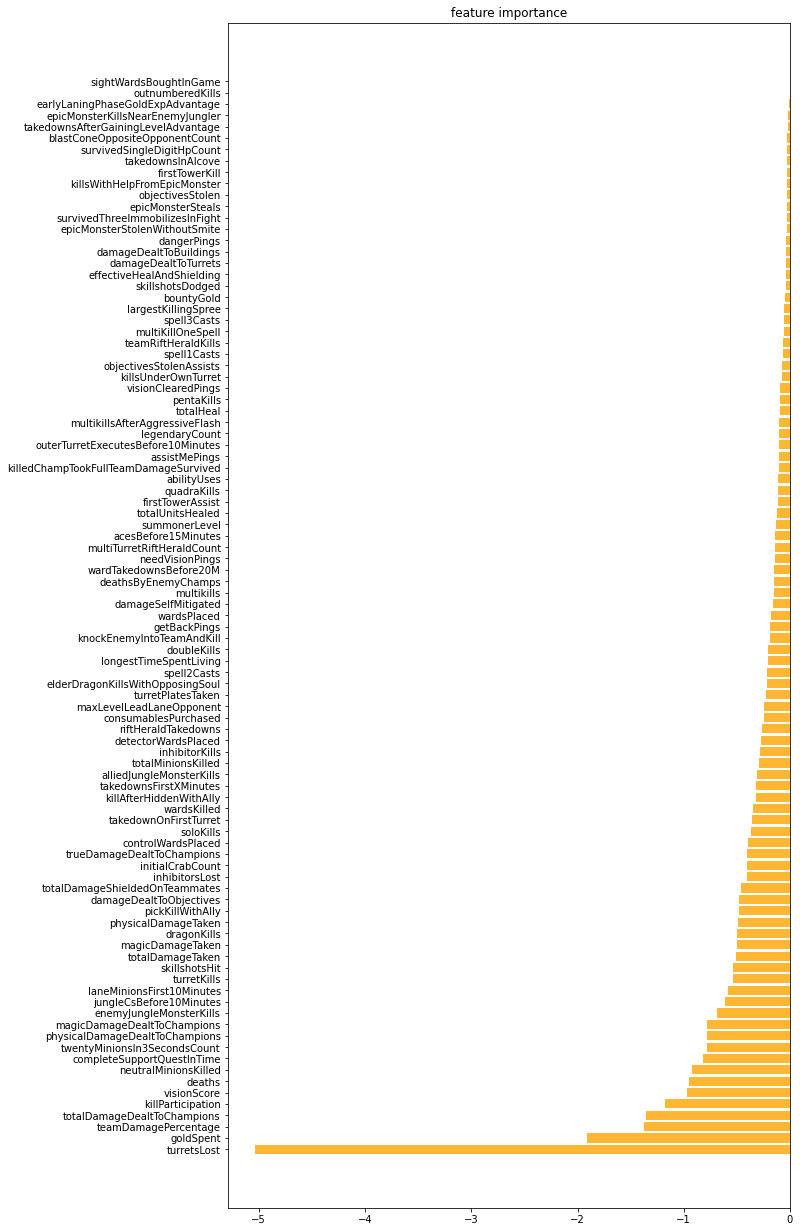

In [59]:
# define dataset
y = data_mid.win.astype('int')
X = data_mid.drop(["teamPosition", "win"], axis=1)
# define the model
model = LogisticRegression(penalty='l2')
# fit the model
model.fit(X, y)
# get importance
importance = model.coef_[0]

feas = pd.DataFrame()
feas['features'] = X.keys()
feas['importance'] = importance
feas = feas.sort_values(by='importance')

feas1 = feas[0:95]
feas2 = feas[95:191]

plot.rc('font', size=10);
fig, axes = plot.subplots(figsize=(11,17))
axes.barh(np.arange(feas1.shape[0]), feas1.importance.values, alpha=0.8,color='orange')
axes.set_title("feature importance")
axes.set_yticks(np.arange(feas1.shape[0]))
axes.set_yticklabels(feas1.features.values, rotation='horizontal')

plot.show()

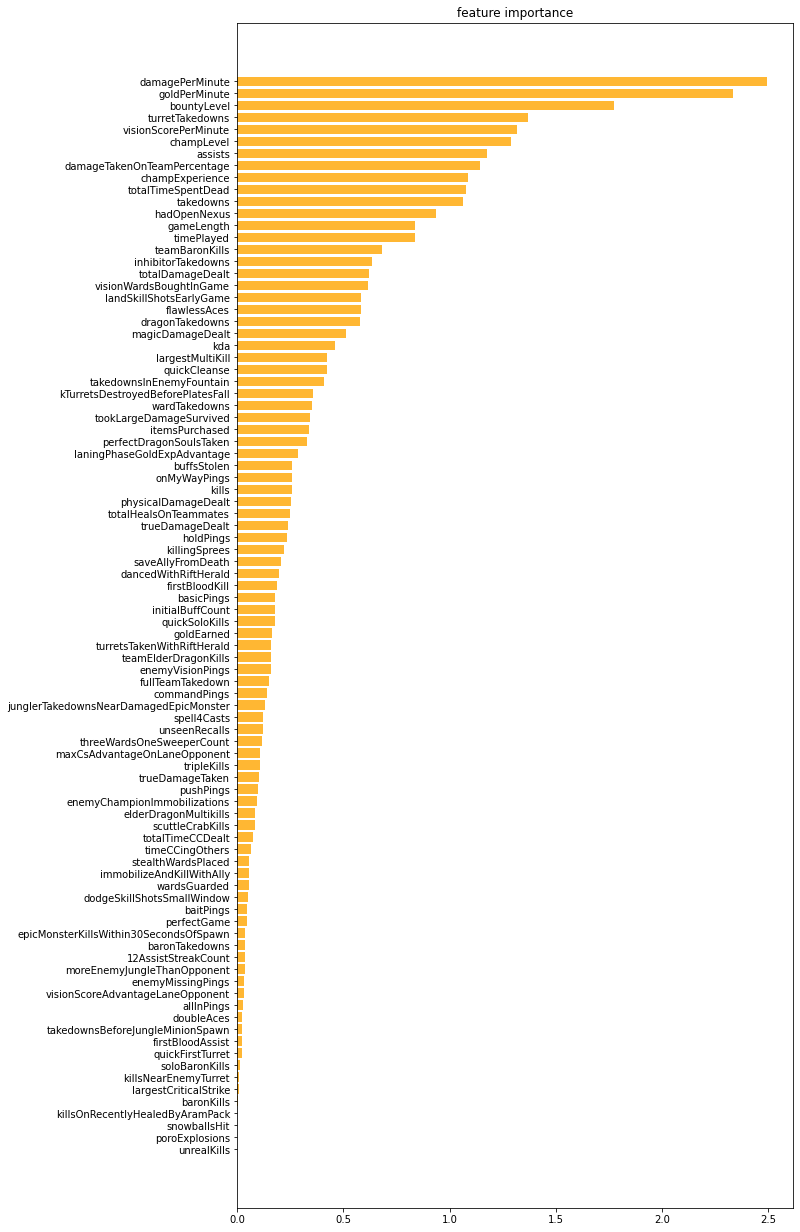

In [60]:
fig, axes = plot.subplots(figsize=(11,17))
axes.barh(np.arange(feas2.shape[0]), feas2.importance.values, alpha=0.8,color='orange')
axes.set_title("feature importance")
axes.set_yticks(np.arange(feas2.shape[0]))
axes.set_yticklabels(feas2.features.values, rotation='horizontal')
plot.show()

## Train test split and feature selection

In [73]:
y=data_mid.win.astype('int')
X = data_mid[["turretsLost","goldSpent","teamDamagePercentage","killParticipation","totalDamageDealtToChampions","visionScore",
              "deaths","neutralMinionsKilled","visionScorePerMinute","bountyLevel","goldPerMinute",
             "damagePerMinute","turretTakedowns","damageTakenOnTeamPercentage","champLevel","assists"]]
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2,stratify=y)


## Baseline model - most common case

In [74]:
dummy = DummyClassifier(strategy='most_frequent').fit(Xtrain, ytrain)
ydummy = dummy.predict(Xtest)
print(confusion_matrix(ytest, ydummy))
print(classification_report(ytest, ydummy))

[[   0 1172]
 [   0 1172]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1172
           1       0.50      1.00      0.67      1172

    accuracy                           0.50      2344
   macro avg       0.25      0.50      0.33      2344
weighted avg       0.25      0.50      0.33      2344



# hyperparameter tuning and cross valiadation - Logistic Classifier(L2)

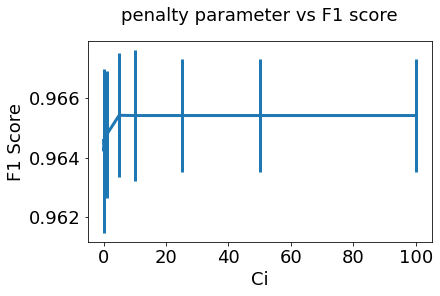

In [75]:
#cross-validation to select the weight C given to the penalty in the cost function.
mean_error=[]
std_error=[]
Ci_range = [0.01, 0.1, 1, 5, 10, 25, 50, 100]
for Ci in Ci_range:
 model = LogisticRegression(C=Ci,penalty='l2');
 scores = cross_val_score(model,Xtrain, ytrain, cv=5, scoring='f1')
 mean_error.append(np.array(scores).mean())
 std_error.append(np.array(scores).std())
plot.rc('font', size=18); plot.rcParams['figure.constrained_layout.use'] = True
plot.errorbar(Ci_range,mean_error,yerr=std_error,linewidth=3)
plot.title("penalty parameter vs F1 score",fontsize=18,pad=20)
plot.xlabel('Ci'); plot.ylabel('F1 Score')
plot.show()

## logistic classifier penalty l2 C=1

In [76]:
lr = LogisticRegression(penalty='l2',C=1,solver='lbfgs')
lr.fit(Xtrain,ytrain)
y_pred = lr.predict(Xtest)
print(confusion_matrix(ytest, y_pred))
print(classification_report(ytest, y_pred))


[[1131   41]
 [  41 1131]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1172
           1       0.97      0.97      0.97      1172

    accuracy                           0.97      2344
   macro avg       0.97      0.97      0.97      2344
weighted avg       0.97      0.97      0.97      2344



## hyperparameter tuning and cross valiadation - Linear SVM

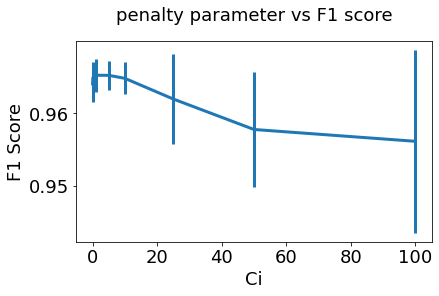

In [77]:
#cross-validation to select the weight C given to the penalty in the cost function.
mean_error=[]
std_error=[]
Ci_range = [0.01, 0.1, 1, 5, 10, 25, 50, 100]
for Ci in Ci_range:
 model = LinearSVC(C=Ci);
 scores = cross_val_score(model,Xtrain, ytrain, cv=5, scoring='f1')
 mean_error.append(np.array(scores).mean())
 std_error.append(np.array(scores).std())
plot.rc('font', size=18); plot.rcParams['figure.constrained_layout.use'] = True
plot.errorbar(Ci_range,mean_error,yerr=std_error,linewidth=3)
plot.title("penalty parameter vs F1 score",fontsize=18,pad=20)
plot.xlabel('Ci'); plot.ylabel('F1 Score')
plot.show()

## Linear SVM C=1

In [78]:
svm = LinearSVC(C=1)
svm.fit(Xtrain,ytrain)
y_pred1 = svm.predict(Xtest)
print(confusion_matrix(ytest, y_pred1))
print(classification_report(ytest, y_pred1))

[[1132   40]
 [  41 1131]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1172
           1       0.97      0.97      0.97      1172

    accuracy                           0.97      2344
   macro avg       0.97      0.97      0.97      2344
weighted avg       0.97      0.97      0.97      2344



## ROC curve

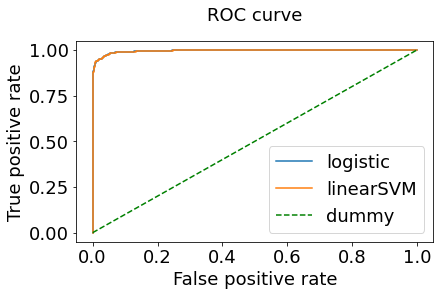

In [79]:
fpr, tpr, _ = roc_curve(ytest,lr.decision_function(Xtest))
plot.plot(fpr,tpr)
fpr1, tpr1, _ = roc_curve(ytest,svm.decision_function(Xtest))
plot.plot(fpr1,tpr1)
fpr2, tpr2, _ = roc_curve(ytest,ydummy)
plot.title("ROC curve",fontsize=18,pad=20)
plot.plot(fpr2,tpr2,color='green',linestyle='--')
plot.xlabel('False positive rate')
plot.ylabel('True positive rate')
plot.legend(["logistic","linearSVM", "dummy"]) 
plot.show()